## Computer Vision Project using GPU and Transfer Learning

In [ ]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Switch and Verify GPU (For Google Colab)

In [ ]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

## Image classification without transfer learning


In [ ]:
#  Load cifar-10 data and split it to training and test

from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [ ]:
# print out data shape

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [ ]:
# print out a random image in x_train as numpy array
x_train[15]

array([[[100, 168, 231],
        [100, 168, 229],
        [101, 167, 230],
        ...,
        [ 95, 165, 231],
        [ 94, 165, 228],
        [ 95, 167, 229]],

       [[103, 170, 230],
        [103, 168, 228],
        [104, 168, 226],
        ...,
        [ 97, 167, 229],
        [ 97, 166, 227],
        [ 97, 168, 229]],

       [[107, 174, 233],
        [106, 172, 230],
        [106, 173, 229],
        ...,
        [100, 170, 230],
        [100, 170, 230],
        [101, 172, 232]],

       ...,

       [[165, 178, 177],
        [159, 170, 167],
        [167, 177, 170],
        ...,
        [ 75, 117, 154],
        [ 75, 120, 157],
        [ 72, 120, 158]],

       [[158, 174, 172],
        [173, 186, 182],
        [182, 193, 188],
        ...,
        [ 76, 119, 154],
        [ 75, 119, 153],
        [ 77, 121, 154]],

       [[161, 176, 174],
        [162, 176, 172],
        [160, 171, 169],
        ...,
        [ 98, 137, 167],
        [129, 160, 183],
        [162, 185, 202]]

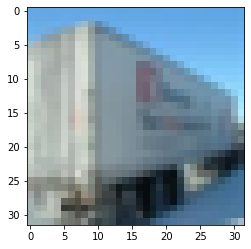

In [ ]:
# print it out as image

import matplotlib.pyplot as plt

plt.imshow(x_train[15])

In [ ]:
# Convert y_train from 2D to 1D 

y_train = y_train.reshape(50000)


In [ ]:
y_train.shape

(50000,)

In [ ]:
# Convert y_test from 2D to 1D 

y_test = y_test.reshape(10000)


In [ ]:
y_test.shape

(10000,)

In [ ]:
# Convert class vectors to one hot format

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Convert data from int to float and normalize it

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

###  CNN model initialization




In [ ]:
model = Sequential()

input_shape = x_train.shape[1:]
batch_size = 64

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(450, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))



In [ ]:
# Print model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0

### Model compile, fit and training

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-5), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True)

import time
start_time = time.time()

model.fit(x_train, y_train, batch_size=batch_size, epochs=50, verbose=2, 
          validation_data=(x_test, y_test), callbacks=[monitor,checkpointer])

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
782/782 - 11s - loss: 1.6331 - accuracy: 0.4005 - val_loss: 1.2940 - val_accuracy: 0.5384 - 11s/epoch - 14ms/step
Epoch 2/50
782/782 - 4s - loss: 1.2640 - accuracy: 0.5447 - val_loss: 1.0879 - val_accuracy: 0.6240 - 4s/epoch - 5ms/step
Epoch 3/50
782/782 - 4s - loss: 1.1143 - accuracy: 0.6039 - val_loss: 0.9825 - val_accuracy: 0.6542 - 4s/epoch - 6ms/step
Epoch 4/50
782/782 - 4s - loss: 1.0184 - accuracy: 0.6394 - val_loss: 0.9220 - val_accuracy: 0.6699 - 4s/epoch - 5ms/step
Epoch 5/50
782/782 - 4s - loss: 0.9400 - accuracy: 0.6676 - val_loss: 0.8638 - val_accuracy: 0.7037 - 4s/epoch - 5ms/step
Epoch 6/50
782/782 - 4s - loss: 0.8770 - accuracy: 0.6911 - val_loss: 0.7818 - val_accuracy: 0.7274 - 4s/epoch - 5ms/step
Epoch 7/50
782/782 - 4s - loss: 0.8409 - accuracy: 0.7023 - val_loss: 0.7772 - val_accuracy: 0.7321 - 4s/epoch - 5ms/step
Epoch 8/50
782/782 - 4s - loss: 0.8069 - accuracy: 0.7180 - val_loss: 0.7696 - val_accuracy: 0.7314 - 4s/epoch - 5ms/step
Epoch 9/50
782/782 - 

### Precision, Recall,  F1 score, and classification_report



In [ ]:
from sklearn import metrics

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)


score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))

f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
   
print(metrics.classification_report(y_true, pred))


Test loss: 0.60746169090271
Test accuracy: 0.7997000217437744
313/313 [==============================] - 1s 2ms/step
Accuracy: 0.7997
Averaged F1: 0.7982263812646532
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1000
           1       0.91      0.90      0.91      1000
           2       0.76      0.69      0.72      1000
           3       0.64      0.62      0.63      1000
           4       0.73      0.83      0.77      1000
           5       0.76      0.64      0.70      1000
           6       0.78      0.88      0.83      1000
           7       0.87      0.82      0.84      1000
           8       0.87      0.90      0.88      1000
           9       0.86      0.86      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



Image (#11): 
Predicted: horse || Actual: horse


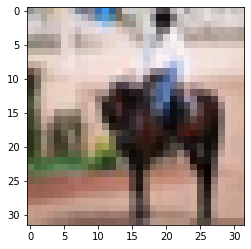

In [ ]:
m = {0: 'frog', 1: 'cat', 2: 'dog', 3: 'automobile', 4: 'deer', 5: 'bird', 6: 'airplane', 7: 'truck', 8: 'ship', 9: 'horse'}

s_img1, s_img2, s_img3, s_img4 = 11, 125, 3565, 9797
img1, img2, img3, img4 = x_train[s_img1], x_train[s_img2], x_train[s_img3], x_train[s_img4]

plt.imshow(img1)
print("Image (#{}): ".format(s_img1))
print("Predicted: {} || Actual: {}".format(m.get(pred[s_img1]), m.get(y_true[s_img1])))


Image (#125): 
Predicted: dog || Actual: frog


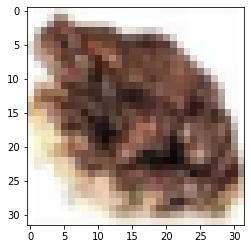

In [ ]:
plt.imshow(img2)
print("Image (#{}): ".format(s_img2))
print("Predicted: {} || Actual: {}".format(m.get(pred[s_img2]), m.get(y_true[s_img2])))

Image (#3565): 
Predicted: cat || Actual: cat


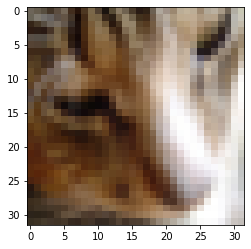

In [ ]:
plt.imshow(img3)
print("Image (#{}): ".format(s_img3))
print("Predicted: {} || Actual: {}".format(m.get(pred[s_img3]), m.get(y_true[s_img3])))



## CNN model with Transfer Learning

In [ ]:
# We load data again.   The data split between train and test sets:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

(x_train, y_train), (x_test, y_test) = (x_train, y_train), (x_test, y_test)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [ ]:
from skimage.transform import resize, rescale

x_train_reshaped = np.zeros(shape=(x_train.shape[0], 64, 64, 3))

for i in range(x_train_reshaped.shape[0]):
    x_train_reshaped[i] = np.zeros(shape=(64, 64, 3))
    #print(x_train_reshaped[i].shape)
    x_train_reshaped[i] = resize(x_train[i], (x_train[i].shape[0] * 2, x_train[i].shape[1] * 2),
                       anti_aliasing=True)

In [ ]:
x_test_reshaped = np.zeros(shape=(x_test.shape[0], 64, 64, 3))

for i in range(x_test_reshaped.shape[0]):
    x_test_reshaped[i] = np.zeros(shape=(64, 64, 3))
    #print(x_test_reshaped[i].shape)
    x_test_reshaped[i] = resize(x_test[i], (x_test[i].shape[0] * 2, x_test[i].shape[1] * 2),
                       anti_aliasing=True)

In [ ]:
y_train, y_test = y_train.reshape(y_train.shape[0]), y_test.reshape(y_test.shape[0])

y_train, y_test = tf.keras.utils.to_categorical(y_train, 10), tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
# double check shape

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


###  Load the pre-trained VGG16 model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer

model_tl = Sequential()

batch_size = 64

for layer in vgg_model.layers:
    model_tl.add(layer)
    #print(layer)

# print out the model summary
model_tl.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

In [ ]:
for layer in model_tl.layers:
    layer.trainable = False
    #print(layer)


In [ ]:
model_tl.add(Flatten())

model_tl.add(Dense(256, activation='relu'))

model_tl.add(Dense(10, activation='softmax'))


###  Model compile, fit and training 



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_tl.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-5), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True)

import time
start_time = time.time()

model_tl.fit(x_train_reshaped, y_train, batch_size=batch_size, epochs=35, verbose=2, 
              validation_data=(x_test_reshaped, y_test), callbacks=[monitor,checkpointer])

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/35
547/547 - 30s - loss: 1.1535 - accuracy: 0.5995 - val_loss: 1.0080 - val_accuracy: 0.6513 - 30s/epoch - 54ms/step
Epoch 2/35
547/547 - 19s - loss: 0.9114 - accuracy: 0.6824 - val_loss: 0.9704 - val_accuracy: 0.6634 - 19s/epoch - 35ms/step
Epoch 3/35
547/547 - 19s - loss: 0.8179 - accuracy: 0.7143 - val_loss: 0.9177 - val_accuracy: 0.6820 - 19s/epoch - 34ms/step
Epoch 4/35
547/547 - 18s - loss: 0.7633 - accuracy: 0.7329 - val_loss: 0.9199 - val_accuracy: 0.6864 - 18s/epoch - 34ms/step
Epoch 5/35
547/547 - 19s - loss: 0.6965 - accuracy: 0.7532 - val_loss: 0.9209 - val_accuracy: 0.6866 - 19s/epoch - 34ms/step
Epoch 6/35
547/547 - 19s - loss: 0.6439 - accuracy: 0.7747 - val_loss: 0.9196 - val_accuracy: 0.6877 - 19s/epoch - 34ms/step
Epoch 7/35
547/547 - 19s - loss: 0.5943 - accuracy: 0.7921 - val_loss: 0.9519 - val_accuracy: 0.6897 - 19s/epoch - 34ms/step
Epoch 8/35
547/547 - 19s - loss: 0.5511 - accuracy: 0.8076 - val_loss: 0.9623 - val_accuracy: 0.6886 - 19s/epoch - 34ms/step


### Precision, Recall, F1 score, and classification_report

In [ ]:
from sklearn import metrics


score = model_tl.evaluate(x_test_reshaped, y_test, verbose=0)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

y_true = np.argmax(y_test,axis=1)
pred = model_tl.predict(x_test_reshaped)
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))

f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
           
print(metrics.classification_report(y_true, pred))


Test loss: 0.9622797966003418
Test accuracy: 0.6885714530944824
219/219 [==============================] - 4s 16ms/step
Accuracy: 0.6885714285714286
Averaged F1: 0.685759878633234
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       704
           1       0.84      0.80      0.82       689
           2       0.74      0.52      0.61       701
           3       0.55      0.42      0.47       698
           4       0.60      0.71      0.65       722
           5       0.53      0.69      0.60       707
           6       0.78      0.59      0.67       698
           7       0.74      0.74      0.74       702
           8       0.69      0.88      0.77       686
           9       0.84      0.72      0.78       693

    accuracy                           0.69      7000
   macro avg       0.70      0.69      0.69      7000
weighted avg       0.70      0.69      0.69      7000



Image (#11): 
Predicted: horse || Actual: horse


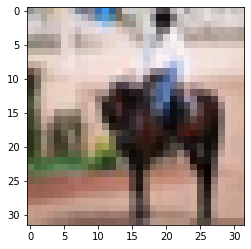

In [ ]:
m = {0: 'frog', 1: 'cat', 2: 'dog', 3: 'automobile', 4: 'deer', 5: 'bird', 6: 'airplane', 7: 'truck', 8: 'ship', 9: 'horse'}

s_img1, s_img2, s_img3, s_img4 = 11, 125, 3565, 9797
img1, img2, img3, img4 = x_train[s_img1], x_train[s_img2], x_train[s_img3], x_train[s_img4]

plt.imshow(img1)
print("Image (#{}): ".format(s_img1))
print("Predicted: {} || Actual: {}".format(m.get(pred[s_img1]), m.get(y_true[s_img1])))


Image (#125): 
Predicted: ship || Actual: frog


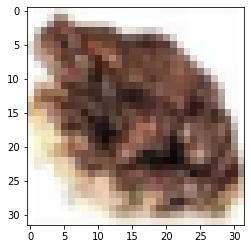

In [ ]:
plt.imshow(img2)
print("Image (#{}): ".format(s_img2))
print("Predicted: {} || Actual: {}".format(m.get(pred[s_img2]), m.get(y_true[s_img2])))

Image (#3565): 
Predicted: cat || Actual: cat


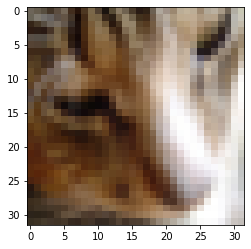

In [ ]:
plt.imshow(img3)
print("Image (#{}): ".format(s_img3))
print("Predicted: {} || Actual: {}".format(m.get(pred[s_img3]), m.get(y_true[s_img3])))